In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# List visible physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Physical GPUs:", gpus)

# Enable memory growth for each GPU (prevents TensorFlow from grabbing all memory)
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Could not set memory growth on {gpu}: {e}")

# List all runtime devices
print("\nRuntime devices:")
for device in device_lib.list_local_devices():
    print(device.name, "-", device.device_type)


2025-07-22 12:59:48.418267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753176588.499072    4307 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753176588.522080    4307 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753176588.710014    4307 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753176588.710052    4307 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753176588.710057    4307 computation_placer.cc:177] computation placer alr

Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Runtime devices:
/device:CPU:0 - CPU
/device:GPU:0 - GPU


I0000 00:00:1753176591.526680    4307 gpu_device.cc:2019] Created device /device:GPU:0 with 3770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


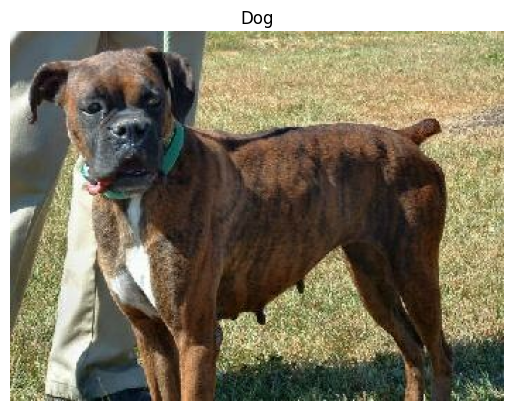

2025-07-22 13:15:38.664329: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

ds = tfds.load('cats_vs_dogs', split='train[:5%]', as_supervised=True)
for image, label in ds.take(1):
    plt.imshow(image)
    plt.title("Cat" if label == 0 else "Dog")
    plt.axis('off')
    plt.show()

In [18]:

        # Splitting dataset to 80% training and 20% validation

import tensorflow_datasets as tfds


def preprocess(img, label):
    img = tf.image.resize(img, (128, 128))  # Resize to fixed input size
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img, label


train_split = 'train[:80%]'
val_split = 'train[80%:]'

raw_train_ds = tfds.load('cats_vs_dogs', split=train_split, as_supervised=True)
raw_val_ds = tfds.load('cats_vs_dogs', split=val_split, as_supervised=True)


train_ds = raw_train_ds.map(preprocess).batch(8).prefetch(tf.data.AUTOTUNE)
val_ds = raw_val_ds.map(preprocess).batch(8).prefetch(tf.data.AUTOTUNE)

In [21]:

        

class ResNetBlock(tf.keras.Model):
    def __init__(self, filters, downsample=False):
        super().__init__()
        self.filters = filters
        self.downsample = downsample
        self.stride = 2 if downsample else 1   # with downsampling = True we reduce the dimentions by 2 

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", strides=self.stride)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.projection = None

    def build(self, input_shape):
        input_channels = input_shape[-1]
        if self.downsample or input_channels != self.filters:
            self.projection = tf.keras.layers.Conv2D(
                self.filters, kernel_size=3, padding="same", strides=self.stride  #kernel_size is increased to 3 
            )
        else:
            self.projection = lambda x: x

    def call(self, inputdata): # in every block there is a Conv->BatchNormalization->Relu->conv->BatchNormalization->(projection with conv if needed)->Idenity->ReLU
        x = self.conv1(inputdata)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        shortcut = self.projection(inputdata)
        x = x + shortcut
        return self.relu(x)




In [22]:

# 1 -- accuracy: 0.8869 - loss: 0.2640 - val_accuracy: 0.8442 - val_loss: 0.3469
# 2 --- accuracy: 0.8738 - loss: 0.2905 - val_accuracy: 0.8298 - val_loss: 0.4356

inputs = tf.keras.Input(shape=(128, 128, 3))

x = ResNetBlock(5)(inputs)
x = ResNetBlock(5)(x)
x = ResNetBlock(5)(x)
x = ResNetBlock(10, downsample=True)(x)
x = ResNetBlock(10)(x)
x = ResNetBlock(10)(x)
x = ResNetBlock(10)(x)
x = ResNetBlock(20, downsample=True)(x)
x = ResNetBlock(20)(x)
x = ResNetBlock(20)(x)
x = ResNetBlock(20)(x)
x = ResNetBlock(40, downsample=True)(x)
x = ResNetBlock(40)(x)
x = ResNetBlock(40)(x)
x = ResNetBlock(40)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(2, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - accuracy: 0.6182 - loss: 0.6547 - val_accuracy: 0.5183 - val_loss: 1.6514
Epoch 2/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7363 - loss: 0.5305 - val_accuracy: 0.7814 - val_loss: 0.4650
Epoch 3/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7733 - loss: 0.4756 - val_accuracy: 0.7618 - val_loss: 0.5157
Epoch 4/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.8019 - loss: 0.4277 - val_accuracy: 0.8059 - val_loss: 0.4437
Epoch 5/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.8293 - loss: 0.3739 - val_accuracy: 0.8128 - val_loss: 0.4379
Epoch 6/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.8535 - loss: 0.3311 - val_accuracy: 0.7997 - val_loss: 0.4808
Epoch 7/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.8738 - loss: 0.2905 - val_accuracy: 0.8298 - val_loss: 0.4356
Epoch 8/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.8943 -

In [23]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_33 (ResNetBlock)  │ (None, 128, 128, 5)    │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_34 (ResNetBlock)  │ (None, 128, 128, 5)    │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_35 (ResNetBlock)  │ (None, 128, 128, 5)    │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_36 (ResNetBlock)  │ (None, 64, 64, 10)     │         1,910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_37 (ResNetBlock)  │ (None, 64, 64, 10)     │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_38 (ResNetBlock)  │ (None, 64, 64, 10)     │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_39 (ResNetBlock)  │ (None, 64, 64, 10)     │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_40 (ResNetBlock)  │ (None, 32, 32, 20)     │         7,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_41 (ResNetBlock)  │ (None, 32, 32, 20)     │         7,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_42 (ResNetBlock)  │ (None, 32, 32, 20)     │         7,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_43 (ResNetBlock)  │ (None, 32, 32, 20)     │         7,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_44 (ResNetBlock)  │ (None, 16, 16, 40)     │        29,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_45 (ResNetBlock)  │ (None, 16, 16, 40)     │        29,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_46 (ResNetBlock)  │ (None, 16, 16, 40)     │        29,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_47 (ResNetBlock)  │ (None, 16, 16, 40)     │        29,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 40)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            82 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 464,748 (1.77 MB)

 Trainable params: 154,522 (603.60 KB)

 Non-trainable params: 1,180 (4.61 KB)

 Optimizer params: 309,046 (1.18 MB)

In [24]:
class ResNetBlock(tf.keras.Model):
    def __init__(self, filters, downsample=False):
        super().__init__()
        self.filters = filters
        self.downsample = downsample
        self.stride = 2 if downsample else 1

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", strides=self.stride)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()

    def build(self, input_shape):
        self.input_channels = input_shape[-1]
        self.use_proj = self.downsample or (self.input_channels != self.filters)
        if self.downsample:
            self.pool = tf.keras.layers.AveragePooling2D(pool_size=3, strides=2, padding="same")
        else:
            self.pool = lambda x: x

    def call(self, inputdata):
        x = self.conv1(inputdata)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        shortcut = self.pool(inputdata)

        input_channels = self.input_channels
        if input_channels < self.filters:
            pad_channels = self.filters - input_channels
            pad = tf.zeros_like(shortcut[..., :pad_channels])
            shortcut = tf.concat([shortcut, pad], axis=-1)
        elif input_channels > self.filters:
            shortcut = shortcut[..., :self.filters]

        x = x + shortcut
        return self.relu(x)
# replaced conv 1x1 layer for downsampling with a AveragePooling2D s=2

In [25]:
# increased performance by swaping 3x3conv with a AvaragePooling2D for downsampling
# 1 -- accuracy: 0.8804 - loss: 0.2874 - val_accuracy: 0.8783 - val_loss: 0.3150
# 2 -- accuracy: 0.8718 - loss: 0.2970 - val_accuracy: 0.8790 - val_loss: 0.2885

inputs = tf.keras.Input(shape=(128, 128, 3))

x = ResNetBlock(5)(inputs)
x = ResNetBlock(5)(x)
x = ResNetBlock(5)(x)
x = ResNetBlock(10, downsample=True)(x)
x = ResNetBlock(10)(x)
x = ResNetBlock(10)(x)
x = ResNetBlock(10)(x)
x = ResNetBlock(20, downsample=True)(x)
x = ResNetBlock(20)(x)
x = ResNetBlock(20)(x)
x = ResNetBlock(20)(x)
x = ResNetBlock(40, downsample=True)(x)
x = ResNetBlock(40)(x)
x = ResNetBlock(40)(x)
x = ResNetBlock(40)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(2, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.6120 - loss: 0.6783 - val_accuracy: 0.6821 - val_loss: 0.7250
Epoch 2/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7032 - loss: 0.5791 - val_accuracy: 0.6728 - val_loss: 0.6933
Epoch 3/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.7458 - loss: 0.5170 - val_accuracy: 0.7513 - val_loss: 0.5106
Epoch 4/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.7807 - loss: 0.4537 - val_accuracy: 0.7844 - val_loss: 0.4495
Epoch 5/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.8226 - loss: 0.3934 - val_accuracy: 0.8424 - val_loss: 0.3548
Epoch 6/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.8483 - loss: 0.3434 - val_accuracy: 0.8601 - val_loss: 0.3183
Epoch 7/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.8718 - loss: 0.2970 - val_accuracy: 0.8790 - val_loss: 0.2885
Epoch 8/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.8872 -

In [26]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_48 (ResNetBlock)  │ (None, 128, 128, 5)    │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_49 (ResNetBlock)  │ (None, 128, 128, 5)    │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_50 (ResNetBlock)  │ (None, 128, 128, 5)    │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_51 (ResNetBlock)  │ (None, 64, 64, 10)     │         1,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_52 (ResNetBlock)  │ (None, 64, 64, 10)     │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_53 (ResNetBlock)  │ (None, 64, 64, 10)     │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_54 (ResNetBlock)  │ (None, 64, 64, 10)     │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_55 (ResNetBlock)  │ (None, 32, 32, 20)     │         5,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_56 (ResNetBlock)  │ (None, 32, 32, 20)     │         7,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_57 (ResNetBlock)  │ (None, 32, 32, 20)     │         7,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_58 (ResNetBlock)  │ (None, 32, 32, 20)     │         7,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_59 (ResNetBlock)  │ (None, 16, 16, 40)     │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_60 (ResNetBlock)  │ (None, 16, 16, 40)     │        29,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_61 (ResNetBlock)  │ (None, 16, 16, 40)     │        29,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_62 (ResNetBlock)  │ (None, 16, 16, 40)     │        29,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 40)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            82 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,768 (1.66 MB)

 Trainable params: 144,862 (565.87 KB)

 Non-trainable params: 1,180 (4.61 KB)

 Optimizer params: 289,726 (1.11 MB)